In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys
from IPython.display import Image



def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


# Simple example with Vanilla RNN


<img src="./images/rnn_function.png" width="1000">

RNNs model **sequential data**, meaning they have **sequential memory**. 
An RNN takes in different kind of inputs (text, words, letters, parts of an image, sounds, etc.) in the form of vectors.

It returns different kinds of outputs, such as the next word/letter in a sequence or paired with an feed-forward NN it can return a class etc.


**How RNN works**:

- It uses previous information to affect later ones
- The loop: passes the input forward sequentialy, while *retaining information* about it
- This info is stored in the *hidden state*
- There are only 3 matrices  that contain weights as parameters. These *DON'T change* with the input, they stay the same through the entire sequence.

## Language Model in pure pytorch

Neural Nets in general can have different nubmer of inputs/outputs.

This is according to the application.

<br>
<br>
<br>


<img src="./images/input_outputs.jpeg" width="1000">

We want to build a simple language model that can learn to predict the next letter in a sequence of letters.

<img src="./images/rnn_showcase.png" width="1000">

In [10]:
class VanillaRNN(nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):
        # Syntactic sugar
        super().__init__()
        
        # Needed to formulate the layer shapes
        # The size of the embeddings or the # of features
        self.num_features = num_features
        # The hidden layer mapping size
        self.num_hidden = num_hidden
        # The size of the output classes
        self.num_classes = num_classes
        
        # Network Parameters (default requires_grad=True)
        # Input
        self.Wxh = nn.Parameter(torch.randn((num_features, num_hidden)))
        self.Whh = nn.Parameter(torch.randn((num_hidden, num_hidden)))
        self.bh = nn.Parameter(torch.zeros((num_hidden)))
        
        # Hidden -> Output
        self.Why = nn.Parameter(torch.randn((num_hidden, self.num_classes)))
        self.by = nn.Parameter(torch.zeros((self.num_classes))) 
        
        # Activation
        self.tanh = nn.Tanh()
    
    def init(self):
        # Initialize hidden state to zero
        self.h = torch.zeros((self.num_hidden))
        
    def forward(self, x):
        self.h = self.tanh((x @ self.Wxh) + (self.h @ self.Whh) + self.bh)
        y_output = self.h @ self.Why + self.by
        return y_output

## Questions on pytorch?
 - Why super() ...?
 - Why Parameter and no Tensor?
 - Which activation function for hidden layers? [Check out this for details](https://cs231n.github.io/neural-networks-1/).
     - In sort: RelU (or LeakyRelU) >> tanh >> sigmoid
     
 - @? [PEP-0465](https://legacy.python.org/dev/peps/pep-0465/)

In [4]:
num_features, num_hidden, num_classes = 4, 3, 4
model = VanillaRNN(num_features, num_hidden, num_classes)

# Printing out the module parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

Wxh torch.Size([4, 3])
Whh torch.Size([3, 3])
bh torch.Size([3])
Why torch.Size([3, 4])
by torch.Size([4])


## Simple Mapper to encode a sequence of chars to vectors

In [5]:
import unicodedata
import string

# Flag to limit the vocabulary to lowercase letters only
lowercase_only = False
if lowercase_only:
    # the lowercase letters (a-z) + some special chars will be in our vocab
    characters = " .,;!-':" + string.ascii_lowercase
else:
    # All letters (a-Z) + some special chars will be in our vocab
    characters = " .,;!-':" + string.ascii_letters
    
print(f'Vocabulary: {characters} Size: {len(characters)}')

class SequenceHandler:
    """
    Utility class to vectorize a sequence of characters. We will create one instance of this class for every string we want to feed to our model.
    """
    def __init__(self, original_string, max_number_char=-1, lowercase_only=False):
        """
        - original_string: str,
        the input string to vectorize
        - max_number_char: int,
        whether we want to pad or trim the input sequence. 
        If max_number_char > 0 the input sequence will be trimmed to max_number_char or will be padded with whitespace
        - lowercase_only: bool,
        If True, lowercase the input string first to avoid dropping OOV chars.
        """
        
        # If lowercase vocab, lowercase the input string as well to avoid dropping the
        # OOV capital letters
        if lowercase_only:
            input_string = original_string.lower()
        else:
            input_string = original_string
        # Keep only letters in the vocab
        input_string= "".join([s for s in input_string if s in characters])
        # Trim or pad the sequence
        if max_number_char > 0 :
            if len(input_string) < max_number_char:
                input_string = input_string + " " * (max_number_char - len(input_string))
            else:
                input_string = input_string[:max_number_char]
            
        print(f'Processed string: {original_string} --> {input_string}')
        # Save the input string
        self.string = input_string
        self.num_characters = len(characters)
        
        # Mapper to char and back
        self.char_to_idx = { ch : i for i, ch in enumerate(characters) }
        self.idx_to_char = { i : ch for ch, i in self.char_to_idx.items() }
        
        self.ohe = self.init_ohe()
        self._process()
        self._process_for_cl()
        

    def init_ohe(self):
        """
        This will create a matrix with one hot encoded vectors for each char in the vocab.
        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding of all the chars in the vocab.
        """
        one_hot = np.zeros((self.num_characters,self.num_characters), dtype=np.int8)
        np.fill_diagonal(one_hot, 1)
        return one_hot
    
    def _process(self):
        """
        This will create the X and y variables of the instance. 
        In X we will store the vector representation of the sequence in a (N_seq - 1) x embedding_size tensor.
        In y we will store the corresponding correct char index value for the next character in the sequence. This will be a tensor of size N_seq, containing integers.
        """
        data_torch = torch.tensor([self.ohe[self.char_to_idx[char]] for char in self.string])
        self.X = data_torch[:-1].float()
        self.y = torch.argmax(data_torch[1:], dim=1).long()
      
    # For other purposes
    def _process_for_cl(self):
        """
        This will create the X_cl variable of the instance. 
        In X_cl we will store the vector representation of the sequence in a (N_seq) x embedding_size tensor.
        """
        data_torch = torch.tensor([self.ohe[self.char_to_idx[char]] for char in self.string])
        self.X_cl = data_torch[:].float()
    
    def __repr__(self):
        return self.string
        
    def make_onehot(self, char):
        return torch.Tensor(self.ohe[self.char_to_idx[char]]).float()
    
    def __repr__(self):
        return self.string

Vocabulary:  .,;!-':abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ Size: 60


In [6]:
data = SequenceHandler('hello')
print(f'{data} (length: {len(data.string)})')
print(f'X vectors: {data.X.shape}, Y: {data.y.shape}')
print(f'Input: (in chars)')
print([data.idx_to_char[x_i.item()] for x_i in data.X.argmax(dim=1)])
print(f'Corresponding target output: (in chars)')
print([data.idx_to_char[y_i.item()] for y_i in data.y])

Processed string: hello --> hello
hello (length: 5)
X vectors: torch.Size([4, 60]), Y: torch.Size([4])
Input: (in chars)
['h', 'e', 'l', 'l']
Corresponding target output: (in chars)
['e', 'l', 'l', 'o']


In [12]:
class RNN(nn.Module):
    """
    Wrapper class that will hold the interface for VanillaRNN, LSTMs and GRUs
    """
    cells = {
        "vanilla" : VanillaRNN
        #"LSTM"    : LSTMCell, # for future implementations
        # "GRU"     : GRUCell, # for future implementations
    }
    
    def __init__(self, num_features, num_hidden=10, num_classes=None, cell_type='LSTM'):
        super().__init__()
        # We default to LM
        if num_classes == None:
            num_classes = num_features
        self.cell_type = cell_type
        # print(f"Creating RNN with cell: {cell_type}")
        self.cell = RNN.cells[cell_type](num_features, num_hidden, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for param in self.cell.parameters():
            # Keep track of gradient for backprop
            param.requires_grad_(True)
            # If we deal with weights xavier initialization
            if param.data.ndimension() >= 2:
                nn.init.xavier_uniform_(param.data)
            # Else is a bias term so all zeros
            else: 
                nn.init.zeros_(param.data)
                
    def forward(self, X):
        # Setup outputs container (the output at each step)
        outputs = torch.zeros_like(X)
        
        # Iterate through sequence
        self.cell.init()
        for i, x in enumerate(X):
            outputs[i] = self.cell(x)
            
        return outputs
    
    def generate(self, data, init_char, num_steps=5, output_type='char'):
        """
        Generate text of length num_steps given an initial character.
        """
        # Check for valid character
        if init_char not in data.char_to_idx:
            avail_chars = ",".join(data.char_to_idx.keys())
            print(f"Character not in vocab. Pick another from: {avail_chars}")
            return
        
        # Use both see for example: https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/3
        with torch.no_grad():
            self.eval()

            # Setup feed that will be used to create the next char
            feed = torch.zeros((num_steps, data.num_characters))
            # First time feed buffer contains only the first string
            feed[0] = data.make_onehot(init_char).unsqueeze(dim=0)
            # The output starts obv. with the first given char
            output = [init_char]
            # For the rest of wanted chars
            for predict_i in range(num_steps-1):
                # Update the feed buffer up to the current char
                feed_in = feed[:predict_i+1]
                # Predict the next char in the sequence
                next_chars = self(feed_in)[-1]
                # Get the next char id
                next_char_idx = torch.argmax(next_chars).item()
                # Get the next char
                next_char = data.idx_to_char[next_char_idx]
                # One hot encode the char and update the feed buffer
                feed[predict_i+1] = data.make_onehot(next_char).unsqueeze(dim=0)
                # Update the final output
                output.append(next_char)
            # Concatenate the chars predicted
            if output_type == 'char':
                output_str = "".join(output)
            elif output_type == 'word':
                output_str = " ".join(output)
            else:
                raise NotImplementedError
            return output_str

#### Setup

In [13]:
CELL_TYPE = 'vanilla' # vanilla
num_hidden = 50
net = RNN(num_features=60, num_hidden=num_hidden, cell_type=CELL_TYPE)

for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

LR = 0.001
optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()


N_EPOCHS = 100
print_every_ = 1
end_early = False
seq_i = ""        
losses = []



cell.Wxh torch.Size([60, 50])
cell.Whh torch.Size([50, 50])
cell.bh torch.Size([50])
cell.Why torch.Size([50, 60])
cell.by torch.Size([60])


Epoch 1/100 -- Loss: 4.1822 -- Network out: ht-U-
Epoch 2/100 -- Loss: 4.1369 -- Network out: ht-U-
Epoch 3/100 -- Loss: 4.0920 -- Network out: ht-U-
Epoch 4/100 -- Loss: 4.0475 -- Network out: ht-U-
Epoch 5/100 -- Loss: 4.0033 -- Network out: ht-U-
Epoch 6/100 -- Loss: 3.9594 -- Network out: ht-U-
Epoch 7/100 -- Loss: 3.9157 -- Network out: ht-U-
Epoch 8/100 -- Loss: 3.8720 -- Network out: ht-U-
Epoch 9/100 -- Loss: 3.8282 -- Network out: ht-U-
Epoch 10/100 -- Loss: 3.7843 -- Network out: ht-U-
Epoch 11/100 -- Loss: 3.7401 -- Network out: hehl-
Epoch 12/100 -- Loss: 3.6956 -- Network out: hehl-
Epoch 13/100 -- Loss: 3.6506 -- Network out: hehlo
Epoch 14/100 -- Loss: 3.6049 -- Network out: hehlo
Epoch 15/100 -- Loss: 3.5586 -- Network out: hehlo
Epoch 16/100 -- Loss: 3.5116 -- Network out: hehlo
Epoch 17/100 -- Loss: 3.4636 -- Network out: hehlo
Epoch 18/100 -- Loss: 3.4148 -- Network out: heXMo
Epoch 19/100 -- Loss: 3.3649 -- Network out: heXMo
Epoch 20/100 -- Loss: 3.3140 -- Network 

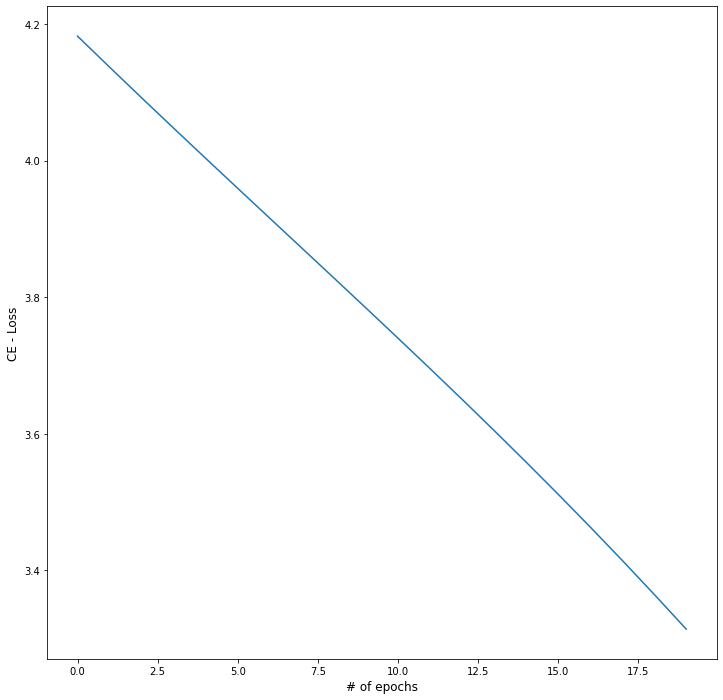

In [14]:
 # Ensure net in training mode
net.train()

for epoch_i in range(N_EPOCHS):
    # Zero out gradients
    optimizer.zero_grad()
    
    # Get net output, calculate loss, and generate gradients
    output = net(data.X)
    loss = criterion(output, data.y)
    # Generate gradients via autograd
    loss.backward() 
    
    # Step
    # -----------------------------------
    # Clip params
    for param in net.parameters():
        if param.grad is None:
            continue
        grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    
    # Track loss
    # CE loss
    losses.append(loss.item())
    
    # Qualitative Eval
    if epoch_i % print_every_ == 0:
        seq_i = net.generate(data, data.string[0], num_steps=len(data.string))
        
        if seq_i == data.string:
            end_early = True
            
        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        print(str_)
        # --------------------------------
    
    if end_early:
        print(f"\nEnding early. Converged in {epoch_i} epochs.")
        break
        

plt.figure(figsize=(12,12))
plt.plot(losses)
plt.xlabel('# of epochs', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

### Questions:
- Do we really need all these epochs? Try tweaking hidden and LR? What's the expected outcome.
- What's the final output? How do we get predictions. Can we calculate accuracy?
- Qualitative early stopping. In the future what?
- Better use a function to wrap-around...

In [34]:
def get_accuracy(y_true, y_pred):
    """
    Simple utility function to get the accuracy given the tensors with the true values (y_true) and
    a tensor with logits or probas.
    Input:
    - y_true: torch.Tensor,
    shape N, containing the class index for N samples
    - y_pred: torch.Tensor,
    shape N x num_classes, containing logit / probas values on each cell for the corresponding class per sample
    Output: accuracy, float range 0-1
    """
    return (y_pred.argmax(dim=1) == y_true).sum().item() / float(len(y_true))
print(f'Accuracy: {100 * get_accuracy(data.y, output):.2f} %')

Accuracy: 75.00 %


In [35]:
# To get probas from logits we can use the F.softmax function

# Get sorted probas per class for first input. First input was 'h' and we expect the most probable value to be 'e'
sorted_values, sorted_class_indexes = F.softmax(output[0,:], dim=0).sort(descending=True)

for i, class_index in enumerate(sorted_class_indexes.data.numpy()):
    print(f'Class: ({class_index}) {data.idx_to_char[class_index]} : {100*sorted_values[i]:.2f} %')

Class: (12) e : 2.55 %
Class: (27) t : 2.23 %
Class: (47) N : 2.17 %
Class: (42) I : 2.13 %
Class: (19) l : 2.11 %
Class: (22) o : 2.09 %
Class: (0)   : 2.07 %
Class: (37) D : 2.00 %
Class: (10) c : 1.96 %
Class: (59) Z : 1.94 %
Class: (3) ; : 1.93 %
Class: (13) f : 1.90 %
Class: (25) r : 1.89 %
Class: (9) b : 1.87 %
Class: (31) x : 1.87 %
Class: (50) Q : 1.84 %
Class: (49) P : 1.84 %
Class: (23) p : 1.82 %
Class: (40) G : 1.80 %
Class: (38) E : 1.79 %
Class: (52) S : 1.78 %
Class: (32) y : 1.72 %
Class: (29) v : 1.69 %
Class: (2) , : 1.67 %
Class: (34) A : 1.67 %
Class: (5) - : 1.67 %
Class: (45) L : 1.66 %
Class: (48) O : 1.66 %
Class: (43) J : 1.63 %
Class: (1) . : 1.61 %
Class: (46) M : 1.60 %
Class: (41) H : 1.60 %
Class: (17) j : 1.57 %
Class: (16) i : 1.57 %
Class: (15) h : 1.56 %
Class: (30) w : 1.55 %
Class: (21) n : 1.55 %
Class: (18) k : 1.53 %
Class: (4) ! : 1.52 %
Class: (26) s : 1.52 %
Class: (56) W : 1.50 %
Class: (36) C : 1.49 %
Class: (28) u : 1.49 %
Class: (24) q : 1.

#### Generate text

In [36]:
init_char = data.string[0]
print(f'Starting with letter: {init_char}')
net.generate(data, init_char, num_steps=len(data.string[0:]))

Starting with letter: h


'hello'

### LSTM

<img src="./images/lstm_equations.png" width="1000">
<br/>
<img src="./images/lstm.png" width="1000">

In [37]:
class LSTMCell(nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        
        # Network Parameters
        # New cell content
        self.Wxh = nn.Parameter(torch.randn((num_features, num_hidden)))
        self.Whh = nn.Parameter(torch.randn((num_hidden, num_hidden)))
        self.bh = nn.Parameter(torch.zeros((num_hidden)))
        
        # Input gate parameters
        self.Wxh_i = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_i = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_i = nn.Parameter(torch.randn_like(self.bh))
        
        # Forget gate parameters
        self.Wxh_f = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_f = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_f = nn.Parameter(torch.randn_like(self.bh))
        
        # Output gate parameters
        self.Wxh_o = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_o = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_o = nn.Parameter(torch.randn_like(self.bh))
        
        # Hidden -> Output
        self.Why = nn.Parameter(torch.randn((num_hidden, self.num_classes)))
        self.by = nn.Parameter(torch.zeros((self.num_classes))) 
        
        # Activations
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def init(self):
        self.h = torch.zeros((self.num_hidden))  # Hidden state
        self.c = torch.zeros((self.num_hidden))  # Cell state
        
    def forward(self, x):
        potential_input = self.tanh((x @ self.Wxh) + (self.h @ self.Whh + self.bh))
        
        # Gate updates
        input_gate = self.sigmoid((x @ self.Wxh_i) + (self.h @ self.Whh_i + self.bh_i))
        forget_gate = self.sigmoid((x @ self.Wxh_f) + (self.h @ self.Whh_f + self.bh_f))
        output_gate = self.sigmoid((x @ self.Wxh_o) + (self.h @ self.Whh_o + self.bh_o))
        
        # Update c and h
        self.c = self.c * forget_gate + potential_input * input_gate
        self.h = output_gate * self.tanh(self.c)
        
        y_output = self.h @ self.Why + self.by
        
        return y_output

### Update setup

Epoch 1/500 -- Loss: 4.1151 -- Network out: hDwJc
Epoch 11/500 -- Loss: 4.0250 -- Network out: hNbgm
Epoch 21/500 -- Loss: 3.9296 -- Network out: hloel
Epoch 31/500 -- Loss: 3.8114 -- Network out: hloel
Epoch 41/500 -- Loss: 3.6418 -- Network out: hello

Ending early. Converged in 40 epochs.


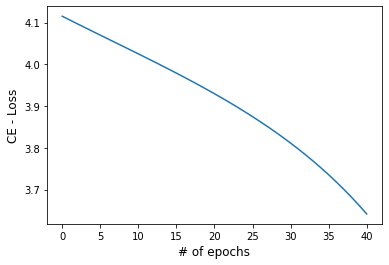

In [38]:
RNN.cells['LSTM'] = LSTMCell
CELL_TYPE = 'LSTM' # vanilla
num_hidden = 50
net = RNN(num_features=data.num_characters, num_hidden=num_hidden, cell_type=CELL_TYPE)

LR = 0.001

optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
losses = []

N_EPOCHS = 500
print_every_ = 10
end_early = False
seq_i = ""


 # Ensure net in training mode
net.train()
for epoch_i in range(N_EPOCHS):
    # Zero out gradients
    optimizer.zero_grad()
    
    # Get net output, calculate loss, and generate gradients
    output = net(data.X)
    loss = criterion(output, data.y)
    # Generate gradients via autodiff
    loss.backward() 
    
    # Step
    # -----------------------------------
    # Clip params
    for param in net.parameters():
        if param.grad is None:
            continue
        grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    
    # Track loss
    # CE loss
    losses.append(loss.item())
    
    # Qualitative Eval
    if epoch_i % print_every_ == 0:
        seq_i = net.generate(data, data.string[0], num_steps=len(data.string))
        
        if seq_i == data.string:
            end_early = True
            
        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        print(str_)
        # --------------------------------
    
    if end_early:
        print(f"\nEnding early. Converged in {epoch_i} epochs.")
        break
    
plt.plot(losses)
plt.xlabel('# of epochs', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

<img src="./images/gru.png" width="1000">

In [39]:
class GRUCell(nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        
        # Network Parameters
        # Potential Input
        self.Wxh = nn.Parameter(torch.randn((num_features, num_hidden)))
        self.Whh = nn.Parameter(torch.randn((num_hidden, num_hidden)))
        self.bh = nn.Parameter(torch.zeros((num_hidden)))
        
        # Update gate parameters
        self.Wxh_u = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_u = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_u = nn.Parameter(torch.randn_like(self.bh))
        
        # Reset gate parameters
        self.Wxh_r = nn.Parameter(torch.randn_like(self.Wxh))
        self.Whh_r = nn.Parameter(torch.randn_like(self.Whh))
        self.bh_r = nn.Parameter(torch.randn_like(self.bh))
        
        # Hidden -> Output
        self.Why = nn.Parameter(torch.randn((num_hidden, self.num_classes)))
        self.by = nn.Parameter(torch.zeros((self.num_classes))) 
        
        # Activations
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def init(self):
        self.h = torch.zeros((self.num_hidden))  # Hidden state
        
    def forward(self, x):
        
        # Gate updates
        update_gate = self.sigmoid((x @ self.Wxh_u) + (self.h @ self.Whh_u + self.bh_u))
        reset_gate = self.sigmoid((x @ self.Wxh_r) + (self.h @ self.Whh_r + self.bh_r))
        
        potential_input = self.tanh((x @ self.Wxh) + (reset_gate @ self.Whh + self.bh))
        
        self.h = self.h * (1-update_gate) + (potential_input * update_gate)
        y_output = self.h @ self.Why + self.by
        
        return y_output

### Add GRU

Epoch 1/500 -- Loss: 4.2630 -- Network out: hMGMG
Epoch 11/500 -- Loss: 3.3905 -- Network out: hllll
Epoch 21/500 -- Loss: 2.6097 -- Network out: hllll
Epoch 31/500 -- Loss: 1.9793 -- Network out: hllll
Epoch 41/500 -- Loss: 1.5481 -- Network out: hllll
Epoch 51/500 -- Loss: 1.2567 -- Network out: hllll
Epoch 61/500 -- Loss: 1.0792 -- Network out: hllll
Epoch 71/500 -- Loss: 0.9534 -- Network out: hllll
Epoch 81/500 -- Loss: 0.8562 -- Network out: hllll
Epoch 91/500 -- Loss: 0.7737 -- Network out: helll
Epoch 101/500 -- Loss: 0.7003 -- Network out: hello

Ending early. Converged in 100 epochs.


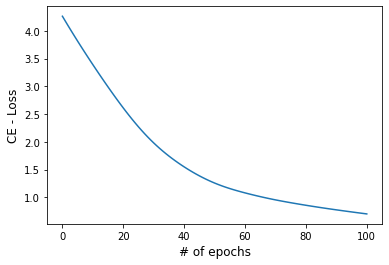

In [40]:
RNN.cells['GRU'] = GRUCell
CELL_TYPE = 'GRU'
num_hidden = 50
net = RNN(num_features=data.num_characters, num_hidden=num_hidden, cell_type=CELL_TYPE)

LR = 0.001

optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
losses = []

N_EPOCHS = 500
print_every_ = 10
end_early = False
seq_i = ""


 # Ensure net in training mode
net.train()
for epoch_i in range(N_EPOCHS):
    # Zero out gradients
    optimizer.zero_grad()
    
    # Get net output, calculate loss, and generate gradients
    output = net(data.X)
    loss = criterion(output, data.y)
    # Generate gradients via autodiff
    loss.backward() 
    
    # Step
    # -----------------------------------
    # Clip params
    for param in net.parameters():
        if param.grad is None:
            continue
        grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    
    # Track loss
    # CE loss
    losses.append(loss.item())
    
    # Qualitative Eval
    if epoch_i % print_every_ == 0:
        seq_i = net.generate(data, data.string[0], num_steps=len(data.string))
        
        if seq_i == data.string:
            end_early = True
            
        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        print(str_)
        # --------------------------------
    
    if end_early:
        print(f"\nEnding early. Converged in {epoch_i} epochs.")
        break
    
plt.plot(losses)
plt.xlabel('# of epochs', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

### Long-term dependecies

In [41]:
data = SequenceHandler('The quick brown fox jumps over the lazy dog')

Processed string: The quick brown fox jumps over the lazy dog --> The quick brown fox jumps over the lazy dog


In [42]:
N_EPOCHS = 500
LR = 0.01
num_hidden = 50

for CELL_TYPE in ['vanilla', 'LSTM', 'GRU']:
    print(f'Fitting {CELL_TYPE}...')
    net = RNN(num_features=data.num_characters, num_hidden=num_hidden, cell_type=CELL_TYPE)
    optimizer = optim.Adam(net.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    losses = []


    end_early = False
    seq_i = ""


    net.train() # Ensure net in training mode
    for epoch_i in range(N_EPOCHS):
        # Zero out gradients
        optimizer.zero_grad()

        # Get net output, calculate loss, and generate gradients
        output = net(data.X)
        loss = criterion(output, data.y)
        loss.backward() # Generate gradients via autodiff

        # Step
        # -----------------------------------
        # Clip params
        for param in net.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -5, 5)
        optimizer.step()
        # -----------------------------------

        # Track loss
        losses.append(loss.item())

        # Qualitative Eval
        if epoch_i % 10 == 0:
            seq_i = net.generate(data, data.string[0], num_steps=len(data.string))

            if seq_i == data.string:
                end_early = True

        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        # print(str_)
        # --------------------------------

        if end_early:
            print(f"\nEnding early. Converged in {epoch_i} epochs.")
            break
    str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
    print(str_)
    print('~'*50)

Fitting vanilla...

Ending early. Converged in 20 epochs.
Epoch 21/500 -- Loss: 0.4322 -- Network out: The quick brown fox jumps over the lazy dog
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting LSTM...

Ending early. Converged in 50 epochs.
Epoch 51/500 -- Loss: 0.2151 -- Network out: The quick brown fox jumps over the lazy dog
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fitting GRU...

Ending early. Converged in 40 epochs.
Epoch 41/500 -- Loss: 0.4050 -- Network out: The quick brown fox jumps over the lazy dog
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Questions:
Why does this happen?
1. Try changing the learning rate (e.g. 0.08).
2. Did the results change? If yes why?

### Complexity

In [43]:

num_features, num_hidden, num_classes = 300, 500, 1
print('Number of Params:..')
for cell_type in ['vanilla', 'LSTM', 'GRU']:
    net = RNN(num_features=data.num_characters, num_hidden=num_hidden, cell_type=cell_type)
    net_param_count = 0
    for name, param in net.named_parameters():
        if param.requires_grad:
            c = 1
            for val in param.shape:
                c *= val
        net_param_count += c
    print(f'{cell_type} : {net_param_count}')

Number of Params:..
vanilla : 310560
LSTM : 1152060
GRU : 871560


## Trump Speech Generator

Sequence now is a series of words. Task is to predict the next word in the series

In [44]:
import re
import nltk
path_to_file = './trump_speeches.txt'

def read_input(path_to_file):
  """
  Reads the input file, get rid of newlines and empty lines, replace with space
  """
  with open(path_to_file, "r") as f:
    input_text = f.read()
  input_text = re.sub("SPEECH\s+\d+", "", input_text)  # Remove the speech headers
  input_text = re.sub("\n+", "\n", input_text) # Remove newlies
  input_text = re.sub("\d+\\\d+\\\d+", "", input_text)  # Remove the dates
  input_text = re.sub(" +", " ", input_text)  # Remove double spaces.
  return ' '.join(input_text.splitlines())

trump_text = read_input(path_to_file)
trump_tokens = nltk.word_tokenize(trump_text) # Tokenize sentences
characters = set([token for token in trump_tokens if len(token) >= 2]) # Keep subset 
trump_tokens = [token for token in trump_tokens if token in characters] # Final vocabulary
print(f'Vocubalary size: {len(characters)}')

FileNotFoundError: [Errno 2] No such file or directory: './trump_speeches.txt'

In [ ]:
import unicodedata
import string

    

class WordHandler(SequenceHandler):
    """
    Utility class to vectorize a sequence of characters. We will create one instance of this class for every string we want to feed to our model.
    """
    def __init__(self, original_string, print_=False):
        """
        - original_string: str,
        the input string to vectorize
        """
        
        # Keep only letters in the vocab

        self.tokens = [word for word in nltk.word_tokenize(original_string) if word in characters]
        self.string = " ".join(self.tokens)
        if print_:
            print(f'Processed string: {original_string} --> {self.string}')
        # Save the input string
        
        self.num_characters = len(characters)
        
        # Mapper to char and back
        self.char_to_idx = { ch : i for i, ch in enumerate(characters) }
        self.idx_to_char = { i : ch for ch, i in self.char_to_idx.items() }
        
        self.ohe = self.init_ohe()
        self._process()
        self._process_for_cl()
        
    def _process(self):
        """
        This will create the X and y variables of the instance. 
        In X we will store the vector representation of the sequence in a (N_seq - 1) x embedding_size tensor.
        In y we will store the corresponding correct char index value for the next character in the sequence. This will be a tensor of size N_seq, containing integers.
        """
        data_torch = torch.tensor([self.ohe[self.char_to_idx[char]] for char in self.tokens])
        self.X = data_torch[:-1].float()
        self.y = torch.argmax(data_torch[1:], dim=1).long()
      
    # For other purposes
    def _process_for_cl(self):
        """
        This will create the X_cl variable of the instance. 
        In X_cl we will store the vector representation of the sequence in a (N_seq) x embedding_size tensor.
        """
        data_torch = torch.tensor([self.ohe[self.char_to_idx[char]] for char in self.tokens])
        self.X_cl = data_torch[:].float()
    

In [ ]:
def generate_batches(tokens, sequence_length=50, batch_size=64, way='random'):
    """
    Simple utility to generate batches of sequences of words from the speeches.
    Sampling is either done randomly or around a word.
    """
    X = []
    for batch_id in range(batch_size):
        if isinstance(way, str):
            if way == 'random':
                # get a random starting point
                r = random.choice(range(len(tokens) - sequence_length - 1))
                sample_seq = tokens[r:r + sequence_length + 1]
            else:
                indices = [i for i, word in enumerate(tokens) if word == way]
                r = random.choice(indices)
                sample_seq = tokens[r - int(sequence_length / 2):r +  int(sequence_length / 2) + 1]
        elif isinstance(way, list):
            indices = [i for i, word in enumerate(tokens) if word == way[0] and tokens[i+1] == way[1]]
            r = random.choice(indices)
            sample_seq = tokens[r: int(r + sequence_length)]
        else:
            raise NotImplementedError
        X.append(" ".join(sample_seq))
       
    return X


In [ ]:
wanted_samples = generate_batches(trump_tokens, way=['Make', 'America'], sequence_length=10, batch_size=30)
wanted_samples
# wanted_samples = generate_batches(trump_tokens, way='Make', sequence_length=4, batch_size=10)
# wanted_samples


In [ ]:
CELL_TYPE = 'GRU' # vanilla
num_hidden = 10
net = RNN(num_features=len(characters), num_hidden=num_hidden, cell_type=CELL_TYPE)

LR = 0.005

optimizer = optim.Adam(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
losses = []

N_EPOCHS = 40
print_every_ = 1
end_early = False
seq_i = ""


 # Ensure net in training mode
net.train()
for epoch_i in range(N_EPOCHS):
    print(f'Epoch: {epoch_i + 1}...')
    # Zero out gradients
    optimizer.zero_grad()
    
    samples = wanted_samples#generate_batches(trump_tokens,  sequence_length=4, batch_size=50, way='random')
    for sample in samples:
        #print(f'Sampled sentence: {sample}')
        data = WordHandler(sample)
        output = net(data.X)
        loss = criterion(output, data.y)
        #print(f'Wanted: {data.tokens[1:]}')
        #print(f'Predicted: {[data.idx_to_char[id_.item()] for id_ in torch.argmax(output, dim=1)]}')
        # Generate gradients via autodiff
        loss.backward() 

        # Step
        # -----------------------------------
        # Clip params
        for param in net.parameters():
            if param.grad is None:
                continue
            grad_val = torch.clamp(param.grad, -1, 1)
        optimizer.step()
        # -----------------------------------

        # Track loss
        # CE loss
        losses.append(loss.item())
    
    # Qualitative Eval
    if epoch_i % print_every_ == 0:
        seq_i = net.generate(data, ("Make"), num_steps=4, output_type='word')
        
        #if seq_i == data.string:
        #    end_early = True
            
        # Stdout
        # --------------------------------
        str_ = f'\rEpoch {epoch_i+1}/{N_EPOCHS} -- Loss: {losses[-1]:0.4f} -- Network out: {seq_i}'
        print(str_)
        # --------------------------------
    
    
plt.plot(losses)
plt.xlabel('# of epochs', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

#### Generate sample text


In [ ]:
net.generate(data, 'Make', 4, output_type='word')

## Recap comments:
- LSTM / GRU >> RNN. LSTM more effective, GRU more efficient.
- Use RelUs and Adam as go to methods.
- Tweak hidden sizes and learning rates according to model performance during training.
- Better to create functions: def train(), def evaluate() ...  and also utilize already existing functionalities (Dataset and DataLoader from torch.utils) to avoid messy code and incosistencies.

## Other resources:

- Book with accompanying torch code:
  - [Deep dive 2 deep learning: RRN Chapter](https://d2l.ai/chapter_recurrent-neural-networks/index.html)
- Posts:
    - [Karpathys famous blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) 
    - [Colah's blog post on LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
    - [Explained extensive RNN post](https://explained.ai/rnn/index.html)
- Applications
    - [Surname classification with RNNs](https://github.com/joosthub/PyTorchNLPBook/blob/master/chapters/chapter_6/classifying-surnames/Chapter-6-Surname-Classification-with-RNNs.ipynb)
    - [LSTM with trainable word embeddings](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)
    - [Emojifying sentences with Glove Embeddings](https://github.com/hiepnguyen034/Emojifier-plus)